<a href="https://colab.research.google.com/github/Mhemd139/MMA_Ai/blob/main/UFC_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install required packages
!pip install transformers datasets torch torchvision pillow opencv-python matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [3]:
# Import libraries
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [8]:
from google.colab import files
import zipfile

# Upload your data
print("📤 Upload your mma_data.zip file...")
uploaded = files.upload()

# Extract the data
print("�� Extracting data...")
with zipfile.ZipFile('mma_data.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

print("✅ Data extracted successfully!")
print("📁 Available folders:")
!ls -la data/

📤 Upload your mma_data.zip file...


Saving mma_data.zip to mma_data.zip
�� Extracting data...
✅ Data extracted successfully!
📁 Available folders:
ls: cannot access 'data/': No such file or directory


In [9]:
import os
import shutil

print("🔧 Fixing file structure...")

# Create the proper directories
os.makedirs('data/blocked_punches', exist_ok=True)
os.makedirs('data/landed_punches', exist_ok=True)
os.makedirs('data/frames', exist_ok=True)

# Move files to correct locations
print("📁 Moving blocked punches...")
for file in os.listdir('.'):
    if file.startswith("data\\blocked_punches\\"):
        new_name = file.replace("data\\blocked_punches\\", "")
        shutil.move(file, f"data/blocked_punches/{new_name}")

print("📁 Moving landed punches...")
for file in os.listdir('.'):
    if file.startswith("data\\landed_punches\\"):
        new_name = file.replace("data\\landed_punches\\", "")
        shutil.move(file, f"data/landed_punches/{new_name}")

print("📁 Moving frames...")
for file in os.listdir('.'):
    if file.startswith("data\\frames\\"):
        new_name = file.replace("data\\frames\\", "")
        shutil.move(file, f"data/frames/{new_name}")

print("✅ File structure fixed!")
print("📁 Checking folders:")
!ls -la data/

🔧 Fixing file structure...
📁 Moving blocked punches...
📁 Moving landed punches...
📁 Moving frames...
✅ File structure fixed!
📁 Checking folders:
total 36
drwxr-xr-x 5 root root  4096 Aug  2 15:01 .
drwxr-xr-x 1 root root 20480 Aug  2 15:01 ..
drwxr-xr-x 2 root root  4096 Aug  2 15:01 blocked_punches
drwxr-xr-x 2 root root  4096 Aug  2 15:01 frames
drwxr-xr-x 2 root root  4096 Aug  2 15:01 landed_punches


�� Dataset Statistics:
   🛡️ Blocked punches: 37 frames
   💥 Landed punches: 23 frames
   �� Total video frames: 156 frames
   📈 Total training samples: 60


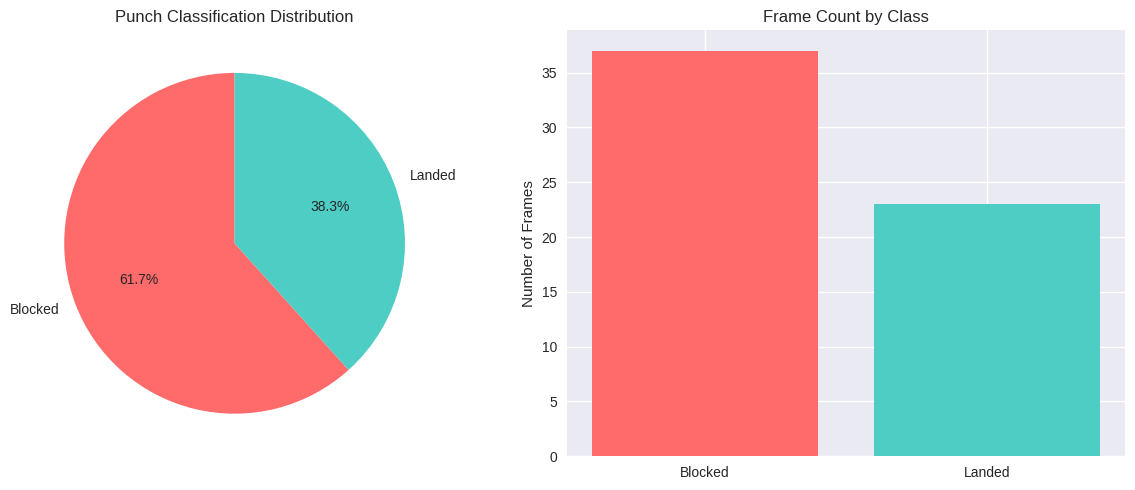

In [10]:
# Count frames in each folder
blocked_dir = "data/blocked_punches"
landed_dir = "data/landed_punches"
frames_dir = "data/frames"

blocked_count = len([f for f in os.listdir(blocked_dir) if f.endswith('.jpg')])
landed_count = len([f for f in os.listdir(landed_dir) if f.endswith('.jpg')])
frames_count = len([f for f in os.listdir(frames_dir) if f.endswith('.jpg')])

print(f"�� Dataset Statistics:")
print(f"   🛡️ Blocked punches: {blocked_count} frames")
print(f"   💥 Landed punches: {landed_count} frames")
print(f"   �� Total video frames: {frames_count} frames")
print(f"   📈 Total training samples: {blocked_count + landed_count}")

# Visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart
labels = ['Blocked', 'Landed']
sizes = [blocked_count, landed_count]
colors = ['#ff6b6b', '#4ecdc4']
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Punch Classification Distribution')

# Bar chart
ax2.bar(labels, sizes, color=colors)
ax2.set_title('Frame Count by Class')
ax2.set_ylabel('Number of Frames')

plt.tight_layout()
plt.show()

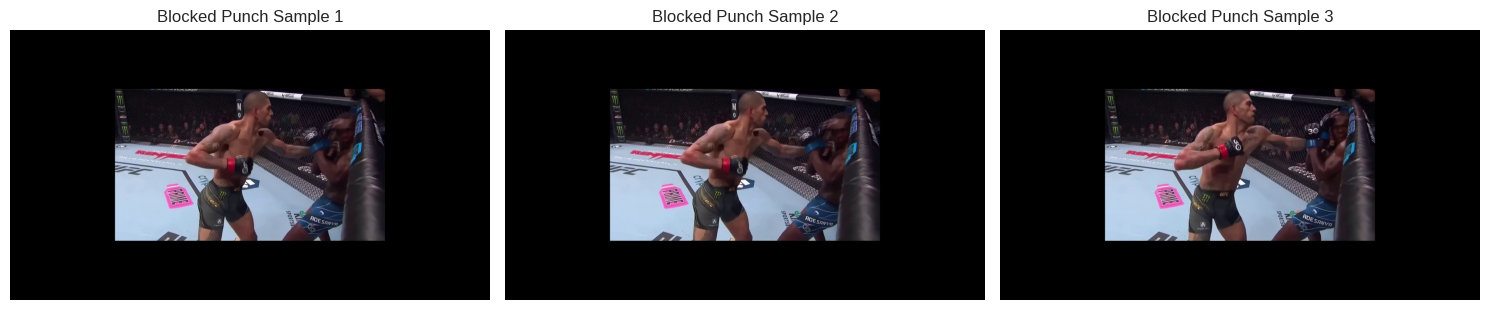

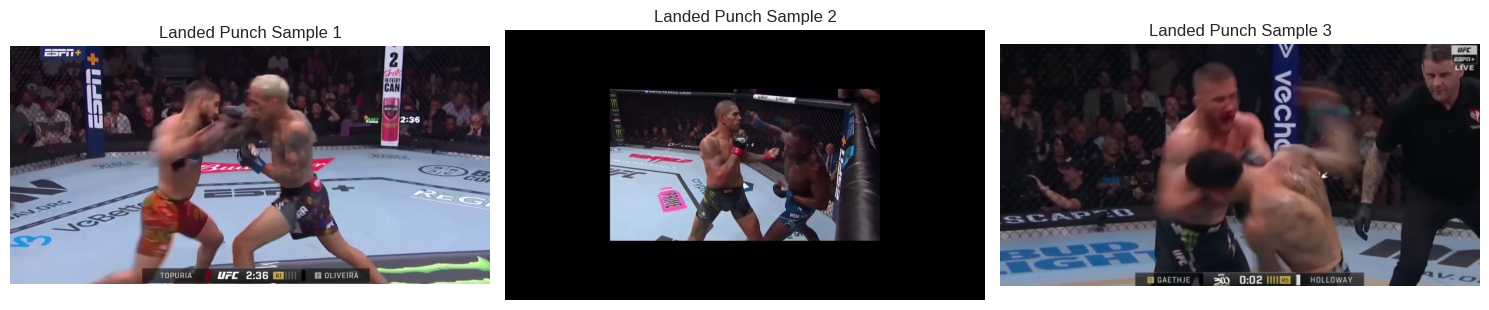

In [11]:
# Display sample images
def show_samples(folder, title, num_samples=3):
    files = [f for f in os.listdir(folder) if f.endswith('.jpg')][:num_samples]

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]

    for i, file in enumerate(files):
        img = Image.open(os.path.join(folder, file))
        axes[i].imshow(img)
        axes[i].set_title(f'{title} Sample {i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Show samples
show_samples(blocked_dir, "Blocked Punch", 3)
show_samples(landed_dir, "Landed Punch", 3)

In [12]:
import torch
from torch.utils.data import Dataset

class PunchDataset(Dataset):
    def __init__(self, blocked_dir, landed_dir, processor):
        self.processor = processor
        self.images = []
        self.labels = []

        # Load blocked punches (label 0)
        print("📥 Loading blocked punches...")
        for frame_file in os.listdir(blocked_dir):
            if frame_file.endswith(".jpg"):
                frame_path = os.path.join(blocked_dir, frame_file)
                try:
                    image = Image.open(frame_path).convert("RGB")
                    self.images.append(image)
                    self.labels.append(0)  # 0 = blocked
                except Exception as e:
                    print(f"⚠️ Skipping {frame_file}: {e}")

        # Load landed punches (label 1)
        print("📥 Loading landed punches...")
        for frame_file in os.listdir(landed_dir):
            if frame_file.endswith(".jpg"):
                frame_path = os.path.join(landed_dir, frame_file)
                try:
                    image = Image.open(frame_path).convert("RGB")
                    self.images.append(image)
                    self.labels.append(1)  # 1 = landed
                except Exception as e:
                    print(f"⚠️ Skipping {frame_file}: {e}")

        print(f"✅ Dataset prepared: {len(self.images)} images")
        print(f"   Blocked punches: {self.labels.count(0)}")
        print(f"   Landed punches: {self.labels.count(1)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Process image with the processor
        inputs = self.processor(image, return_tensors="pt")

        return {
            "pixel_values": inputs["pixel_values"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Setup processor first
model_name = "microsoft/resnet-50"
processor = AutoImageProcessor.from_pretrained(model_name)

# Create custom dataset
full_dataset = PunchDataset(blocked_dir, landed_dir, processor)

# Split dataset
from sklearn.model_selection import train_test_split
train_indices, test_indices = train_test_split(
    range(len(full_dataset)),
    test_size=0.2,
    random_state=42,
    stratify=[full_dataset.labels[i] for i in range(len(full_dataset))]
)

# Create train and test datasets
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
eval_dataset = torch.utils.data.Subset(full_dataset, test_indices)

print(f"\n📊 Split Statistics:")
print(f"   Training: {len(train_dataset)} samples")
print(f"   Testing: {len(eval_dataset)} samples")

# Test a sample
sample = train_dataset[0]
print(f"✅ Sample test successful! Shape: {sample['pixel_values'].shape}")

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


📥 Loading blocked punches...
📥 Loading landed punches...
✅ Dataset prepared: 60 images
   Blocked punches: 37
   Landed punches: 23

📊 Split Statistics:
   Training: 48 samples
   Testing: 12 samples
✅ Sample test successful! Shape: torch.Size([3, 224, 224])


In [13]:
def setup_huggingface_model():
    """Setup the Hugging Face model for fine-tuning"""
    print(" Setting up Hugging Face model...")

    model_name = "microsoft/resnet-50"
    model = AutoModelForImageClassification.from_pretrained(
        model_name,
        num_labels=2,  # blocked vs landed
        ignore_mismatched_sizes=True
    )

    print(f"✅ Model loaded: {model_name}")
    print(f" Number of classes: 2 (blocked/landed)")

    return model

# Setup model
model = setup_huggingface_model()

# Display model info
print(f"\n📈 Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"🔧 Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

 Setting up Hugging Face model...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded: microsoft/resnet-50
 Number of classes: 2 (blocked/landed)

📈 Model Parameters: 23,512,130
🔧 Trainable Parameters: 23,512,130


In [14]:
# Training arguments - FIXED for older transformers version
training_args = TrainingArguments(
    output_dir="./punch-detection-model",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to=None,
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
)

print("🚀 Starting model training...")
print(f"📊 Training for {training_args.num_train_epochs} epochs")
print(f"🎯 Batch size: {training_args.per_device_train_batch_size}")

# Train the model
trainer.train()

# Save the model
trainer.save_model("./punch-detection-model")
print("✅ Model trained and saved!")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


🚀 Starting model training...
📊 Training for 10 epochs
🎯 Batch size: 4


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mhemd-masa (mhemd-masa-no) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.688100,0.692006
2,0.680600,0.695424
3,0.671800,0.681494
4,0.661600,0.659342
5,0.623600,0.630042
6,0.618600,0.601460
7,0.556600,0.565351
8,0.551400,0.525233
9,0.467600,0.483028
10,0.500900,0.477612


✅ Model trained and saved!


📊 Evaluating model performance...



 Evaluation Results:
   Loss: 0.4776
   Accuracy: Calculating manually...
   Accuracy: 1.0000


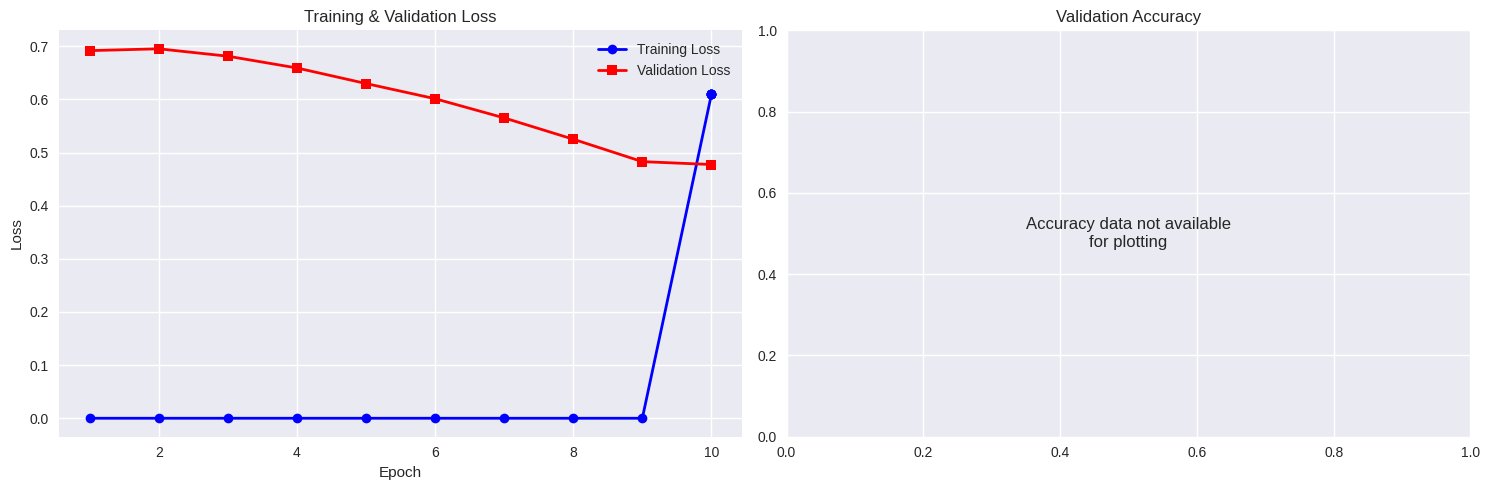


🎉 Training Complete!
   Final Loss: 0.4776
   Final Accuracy: 1.0000
   Model saved to: ./punch-detection-model/


In [19]:
# Evaluate model
print("📊 Evaluating model performance...")
eval_results = trainer.evaluate()

print(f"\n Evaluation Results:")
print(f"   Loss: {eval_results['eval_loss']:.4f}")

# Calculate accuracy manually if not available
if 'eval_accuracy' not in eval_results:
    print("   Accuracy: Calculating manually...")

    # Get predictions
    predictions = trainer.predict(eval_dataset)
    predicted_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = predictions.label_ids

    # Calculate accuracy
    accuracy = np.mean(predicted_labels == true_labels)
    print(f"   Accuracy: {accuracy:.4f}")
else:
    print(f"   Accuracy: {eval_results['eval_accuracy']:.4f}")

# Plot training history - FIXED VERSION
if hasattr(trainer.state, 'log_history'):
    history = trainer.state.log_history

    # Extract metrics with proper filtering
    eval_entries = [log for log in history if 'eval_loss' in log]
    train_entries = [log for log in history if 'train_loss' in log]

    if eval_entries and train_entries:
        # Use eval entries as base since they have epochs
        epochs = [log.get('epoch', 0) for log in eval_entries]
        eval_loss = [log.get('eval_loss', 0) for log in eval_entries]

        # Match train loss to eval epochs
        train_loss = []
        for epoch in epochs:
            # Find closest train loss for this epoch
            train_entry = next((log for log in train_entries if abs(log.get('epoch', 0) - epoch) < 0.1), None)
            train_loss.append(train_entry.get('train_loss', 0) if train_entry else 0)

        # Plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss plot
        ax1.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2, marker='o')
        ax1.plot(epochs, eval_loss, 'r-', label='Validation Loss', linewidth=2, marker='s')
        ax1.set_title('Training & Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Accuracy plot (if available)
        eval_acc_entries = [log for log in history if 'eval_accuracy' in log]
        if eval_acc_entries:
            eval_acc = [log.get('eval_accuracy', 0) for log in eval_acc_entries]
            acc_epochs = [log.get('epoch', 0) for log in eval_acc_entries]
            ax2.plot(acc_epochs, eval_acc, 'g-', label='Validation Accuracy', linewidth=2, marker='o')
            ax2.set_title('Validation Accuracy')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Accuracy')
            ax2.legend()
            ax2.grid(True)
        else:
            ax2.text(0.5, 0.5, 'Accuracy data not available\nfor plotting',
                    ha='center', va='center', transform=ax2.transAxes, fontsize=12)
            ax2.set_title('Validation Accuracy')

        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Insufficient training history for plotting")
else:
    print("⚠️ No training history available for plotting")

print(f"\n🎉 Training Complete!")
print(f"   Final Loss: {eval_results['eval_loss']:.4f}")
print(f"   Final Accuracy: {accuracy:.4f}")
print(f"   Model saved to: ./punch-detection-model/")

🧪 Testing model predictions...


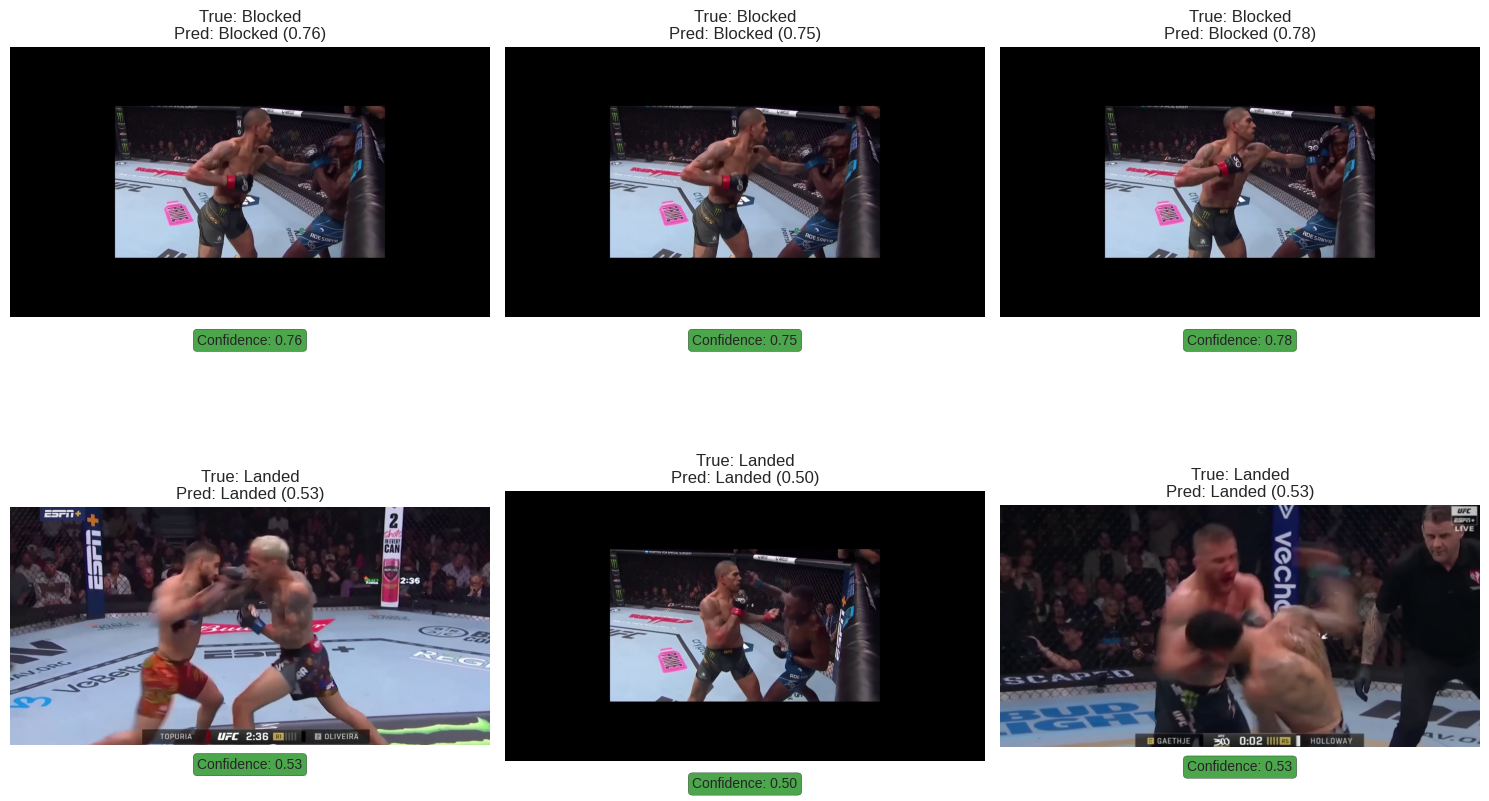

In [20]:
# Load trained model
model = AutoModelForImageClassification.from_pretrained("./punch-detection-model")
processor = AutoImageProcessor.from_pretrained("./punch-detection-model")

def predict_punch(image_path):
    """Predict if a punch is blocked or landed"""
    image = Image.open(image_path).convert("RGB")
    inputs = processor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions).item()
        confidence = predictions[0][predicted_class].item()

    return "Blocked" if predicted_class == 0 else "Landed", confidence

# Test on sample images
print("🧪 Testing model predictions...")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

test_images = []
test_labels = []

# Get sample images from each class
blocked_samples = [f for f in os.listdir(blocked_dir) if f.endswith('.jpg')][:3]
landed_samples = [f for f in os.listdir(landed_dir) if f.endswith('.jpg')][:3]

for i, (sample, label) in enumerate(zip(blocked_samples + landed_samples, ['Blocked']*3 + ['Landed']*3)):
    if i < 3:
        img_path = os.path.join(blocked_dir, sample)
    else:
        img_path = os.path.join(landed_dir, sample)

    prediction, confidence = predict_punch(img_path)

    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f'True: {label}\nPred: {prediction} ({confidence:.2f})')
    axes[i].axis('off')

    # Color code based on correctness
    color = 'green' if prediction == label else 'red'
    axes[i].text(0.5, -0.1, f'Confidence: {confidence:.2f}',
                 transform=axes[i].transAxes, ha='center',
                 bbox=dict(boxstyle='round', facecolor=color, alpha=0.7))

plt.tight_layout()
plt.show()

In [21]:
# Create a ZIP file of your trained model
!zip -r punch_detection_model.zip ./punch-detection-model/

# Download the model
from google.colab import files
files.download('punch_detection_model.zip')

print("✅ Model downloaded! You can now use it in your local project.")

  adding: punch-detection-model/ (stored 0%)
  adding: punch-detection-model/model.safetensors (deflated 7%)
  adding: punch-detection-model/checkpoint-120/ (stored 0%)
  adding: punch-detection-model/checkpoint-120/model.safetensors (deflated 7%)
  adding: punch-detection-model/checkpoint-120/preprocessor_config.json (deflated 44%)
  adding: punch-detection-model/checkpoint-120/trainer_state.json (deflated 78%)
  adding: punch-detection-model/checkpoint-120/optimizer.pt (deflated 8%)
  adding: punch-detection-model/checkpoint-120/config.json (deflated 52%)
  adding: punch-detection-model/checkpoint-120/scheduler.pt (deflated 57%)
  adding: punch-detection-model/checkpoint-120/rng_state.pth (deflated 25%)
  adding: punch-detection-model/checkpoint-120/training_args.bin (deflated 51%)
  adding: punch-detection-model/checkpoint-12/ (stored 0%)
  adding: punch-detection-model/checkpoint-12/model.safetensors (deflated 7%)
  adding: punch-detection-model/checkpoint-12/preprocessor_config.js

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Model downloaded! You can now use it in your local project.
